In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os

In [3]:
AIS_dir = "/home/imonge/Documents/AIS/files"
output_dir = "../../../../data/test_correlation/AIS/AIS.pkl"

In [26]:
#### Clean AIS dataset####

In [5]:
## Retrieve csv files
csv_files = glob.glob(os.path.join(AIS_dir, "*.csv"))
dataframes = []

# Load each file as a DataFrame
for file in csv_files:
    try:
        df = pd.read_csv(file, parse_dates=["datetime"])
        dataframes.append(df)
    except Exception as e:
        print(f"Erreur lors de la lecture de {file} : {e}")

# Merge csv
AIS = pd.concat(dataframes, ignore_index=True)

# Standardise columns names
AIS.rename(columns=lambda x: x.strip().lower(), inplace=True)

# Convert 0 for width and length and draught in NaN
AIS["length"] = AIS["length"].replace(0, pd.NA)
AIS["width"] = AIS["width"].replace(0, pd.NA)
AIS["draught"] = AIS["draught"].replace(0, pd.NA)

/tmp/ipykernel_20990/3078811834.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(file, parse_dates=["datetime"])
/tmp/ipykernel_20990/3078811834.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  AIS = pd.concat(dataframes, ignore_index=True)


In [6]:
## Remove incoherent data
# Datetime duplicates
AIS.drop_duplicates(subset=["mmsi", "datetime"], inplace=True)

# Remove several lengths or widths for one mmsi
mmsi_multi_length = AIS.groupby("mmsi")["length"].nunique()
mmsi_multi_width = AIS.groupby("mmsi")["width"].nunique()

mmsi_invalid = mmsi_multi_length[mmsi_multi_length > 1].index.union(
    mmsi_multi_width[mmsi_multi_width > 1].index
)

AIS = AIS[~AIS["mmsi"].isin(mmsi_invalid)].copy()

In [7]:
## NaN values
# Replace NaN in length, width and draught columns by the known values for each mmsi
mmsi_length_map = AIS.groupby("mmsi")["length"].first()
mmsi_width_map = AIS.groupby("mmsi")["width"].first()
mmsi_draught_map = AIS.groupby("mmsi")["draught"].first()

AIS["length"] = AIS.apply(
    lambda row: mmsi_length_map[row["mmsi"]] if pd.isna(row["length"]) else row["length"], axis=1
)
AIS["width"] = AIS.apply(
    lambda row: mmsi_width_map[row["mmsi"]] if pd.isna(row["width"]) else row["width"], axis=1
)
AIS["draught"] = AIS.apply(
    lambda row: mmsi_draught_map[row["mmsi"]] if pd.isna(row["draught"]) else row["draught"], axis=1
)

# Remove mmsi with no values for length or width
mmsi_with_length = AIS.groupby("mmsi")["length"].apply(lambda x: x.notna().any())
mmsi_with_width = AIS.groupby("mmsi")["width"].apply(lambda x: x.notna().any())
valid_mmsi = mmsi_with_length & mmsi_with_width
AIS = AIS[AIS["mmsi"].isin(valid_mmsi[valid_mmsi].index)].copy()

In [8]:
## Remove speed outliers
# Filter sog above 3 knots
df_speed = AIS[(~AIS["sog"].isna()) & (AIS["sog"] > 3)]

# Calculate 99th percentile
threshold_99 = df_speed["sog"].quantile(0.999)

# Identify outliers
outliers = df_speed[df_speed["sog"] > threshold_99]

AIS = AIS[~AIS.index.isin(outliers.index)].copy()

In [9]:
## Switch "lat" and "lon" columns names
AIS["lat"], AIS["lon"] = AIS["lon"].copy(), AIS["lat"].copy()

In [32]:
## Save dataset as pkl
# Sort by datetime
AIS.sort_values(by="datetime", inplace=True)

# Reset index
AIS.reset_index(drop=True, inplace=True)

# Save dataframe as pkl
AIS.to_pickle(output_dir)

In [33]:
#### Data Verification ####

In [10]:
# AIS dataframe verification
# Datetime duplicates
duplicate_mmsi_datetime = AIS.duplicated(subset=["mmsi", "datetime"]).sum()
print(f"Duplicates mmsi + datetime: {duplicate_mmsi_datetime}")

# Mmsi with different length / width
nb_multi_length = AIS.groupby("mmsi")["length"].nunique()
nb_multi_length = nb_multi_length[nb_multi_length > 1].index

nb_multi_width = AIS.groupby("mmsi")["width"].nunique()
nb_multi_width = nb_multi_width[nb_multi_width > 1].index

nb_multi_both = nb_multi_length.intersection(nb_multi_width)

print(f"mmsi with multiple length: {len(nb_multi_length)}")
print(f"mmsi with multiple width: {len(nb_multi_width)}")
print(f"mmsi with multiple both: {len(nb_multi_both)}")


Duplicates mmsi + datetime: 0
mmsi with multiple length: 0
mmsi with multiple width: 0
mmsi with multiple both: 0


In [35]:
# Nan values
# Number of nan values
total_nan =  AIS.isna().sum().sum()
print(f"Total nan values: {total_nan}")

# Columns corresponding
na_per_column = AIS.isna().sum()
print("Columns corresponding")
print(f"{na_per_column}")

# Number of boats without dimension
mmsi_no_dim = AIS[AIS["length"].isna() & AIS["width"].isna()]["mmsi"].unique()
print(f"Number of boats without dimension: {len(mmsi_no_dim)}")

Total nan values: 209283
Columns corresponding
mmsi             0
datetime         0
lon              0
lat              0
sog              0
cog              0
draught     209283
length           0
width            0
dtype: int64
Number of boats without dimension: 0


In [36]:
length_counts = AIS.groupby("mmsi")["length"].nunique()
width_counts = AIS.groupby("mmsi")["width"].nunique()

mmsi_valid = length_counts[(length_counts == 1) & (width_counts == 1)].index
mmsi_invalid = length_counts[(length_counts > 1) & (width_counts > 1)].index
mmsi_missing = length_counts[length_counts == 0].index
tot_boat = AIS["mmsi"].nunique()
tot_mmsi = len(mmsi_valid) + len(mmsi_invalid) + len(mmsi_missing)

print(f"mmsi avec une seule valeur de longueur et largeur: {len(mmsi_valid)}")
print(f"mmsi avec plusieurs valeurs de longueurs ou largeurs: {len(mmsi_invalid)}")
print(f"mmsi sans valeurs renseignées: {len(mmsi_missing)}")
print(f"Total number of boats (mmsi): {tot_boat}")

mmsi avec une seule valeur de longueur et largeur: 6344
mmsi avec plusieurs valeurs de longueurs ou largeurs: 0
mmsi sans valeurs renseignées: 0
Total number of boats (mmsi): 6344


In [37]:
print(f"Maximum speed : {AIS["sog"].max()} knots")

Maximum speed : 22.2 knots


In [41]:
print("Latitude:", AIS["lat"].head())
print("Longitude:", AIS["lon"].head())

Latitude: 0   -13.572745
1   -12.338248
2   -12.097395
3   -12.716667
4   -12.097275
Name: lat, dtype: float64
Longitude: 0    45.475777
1    45.057370
2    44.072003
3    45.163333
4    44.070917
Name: lon, dtype: float64


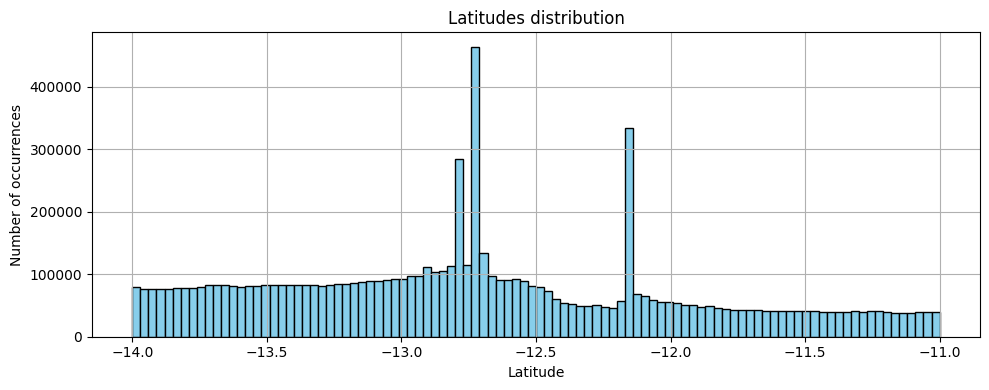

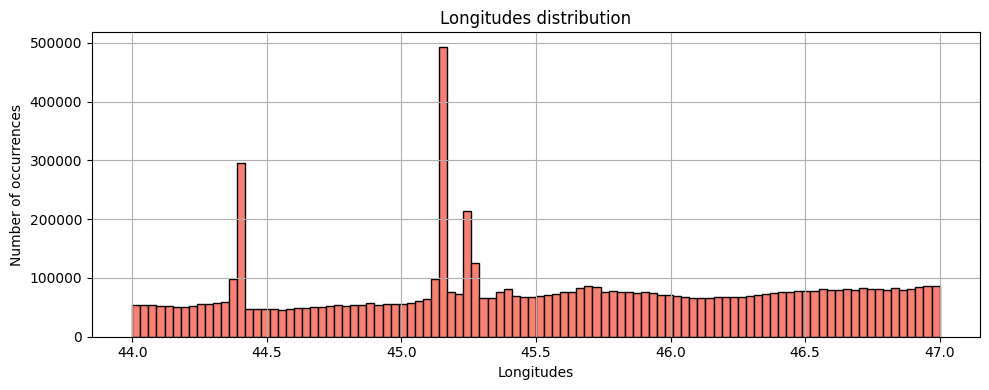

In [11]:
# Check for lon/lat outliers

plt.figure(figsize=(10, 4))
plt.hist(AIS["lat"], bins = 100, color = "skyblue", edgecolor="black")
plt.title("Latitudes distribution")
plt.xlabel("Latitude")
plt.ylabel("Number of occurrences")
plt.grid(True)
plt.tight_layout()
plt.show()
#plt.savefig("lat_histo.png")

# Plot longitude histogram
plt.figure(figsize=(10, 4))
plt.hist(AIS["lon"], bins = 100, color = "salmon", edgecolor="black")
plt.title("Longitudes distribution")
plt.xlabel("Longitudes")
plt.ylabel("Number of occurrences")
plt.grid(True)
plt.tight_layout()
plt.show()
#plt.savefig("lon_histo.png")